## Ideas for feature improvements

1. Analise an amount of account_rk per perty_rk correlation with products
2. Add features
3. Try out more complex architecture


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
sns.set()
sns.set_style('whitegrid')

%matplotlib inline

import numpy as np
from sklearn.manifold import TSNE

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler,OneHotEncoder, MinMaxScaler,RobustScaler,QuantileTransformer,KBinsDiscretizer,Normalizer
from sklearn.model_selection import  KFold
from sklearn.decomposition import PCA,TruncatedSVD
from sklearn.pipeline import FeatureUnion
from sklearn.metrics import log_loss

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, TensorDataset,DataLoader
from IPython import display
from tqdm import trange
import os
from sklearn.metrics.pairwise import cosine_similarity


import torch
import numpy as np

from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from IPython import display
from tqdm import trange
import os

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
products_data = pd.read_csv('./avk_hackathon_data_party_products.csv')
balance_data = pd.read_csv('./avk_hackathon_data_account_x_balance.csv')
socdem_data = pd.read_csv('./avk_hackathon_data_party_x_socdem.csv')


In [3]:
balance_data.shape ## Должно быть (614434, 5) - просто чек, что вся таблица зааплодилась

(614434, 5)

## 1. Смотрим данные и избавляемся от лишних

### products

In [4]:
products_data.shape, products_data.drop_duplicates().shape, products_data.party_rk.nunique()

((50000, 8), (50000, 8), 50000)

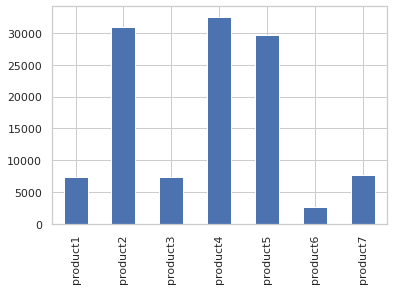

In [5]:
products_data_an = products_data.drop(columns=['party_rk'])
products_data_an.sum().plot(kind='bar')

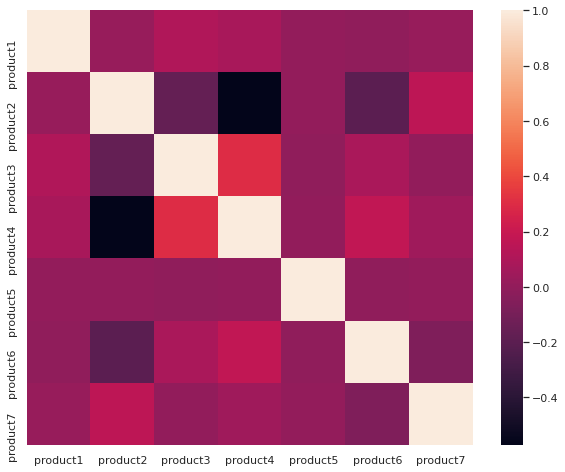

In [6]:
# 3 и 4 скоррелированы
# 2 и 7, 4 и 6 тоже чутка
plt.figure(figsize=(10, 8))
sns.heatmap(products_data_an.corr())

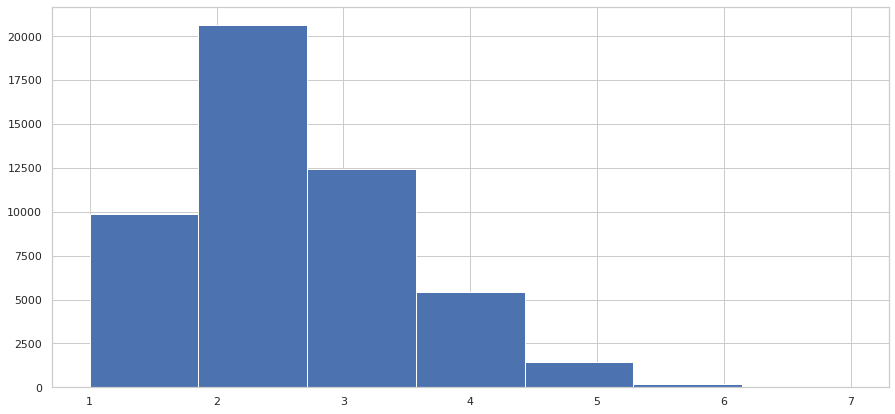

In [7]:
products_data_an.sum(axis=1).hist(bins=7, figsize=(15, 7))

### balance

In [8]:
balance_data.shape

(614434, 5)

In [9]:
"""
дропаем дубли и наны
"""
balance_data = balance_data[balance_data.balance_chng.notna()]
balance_data =  balance_data.drop_duplicates()

balance_data.prev_month = pd.to_datetime(balance_data.prev_month)
balance_data.cur_month = pd.to_datetime(balance_data.cur_month)

balance_data.party_rk.nunique(), balance_data.shape

(49513, (612815, 5))

Text(0.5, 1.0, 'Сколько месяцев на каждый account_rk')

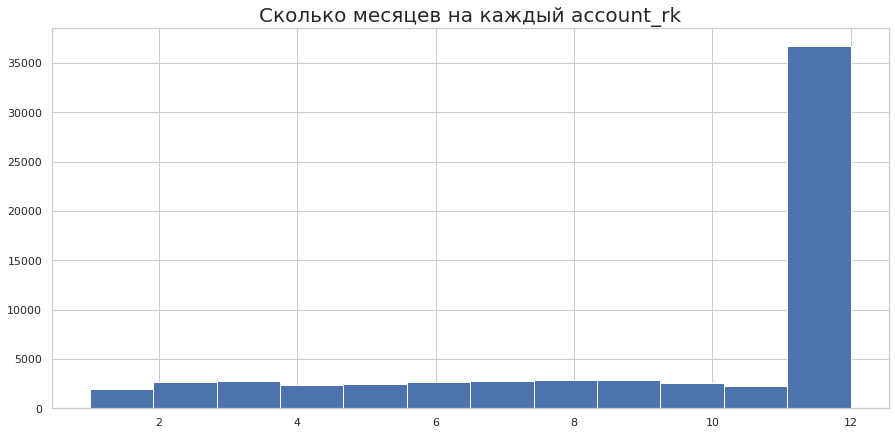

In [10]:
balance_data.groupby(['account_rk']).prev_month.count().hist(figsize=(15, 7), bins=12)
plt.title('Сколько месяцев на каждый account_rk', fontsize=20)


Text(0.5, 1.0, 'Для party_rk')

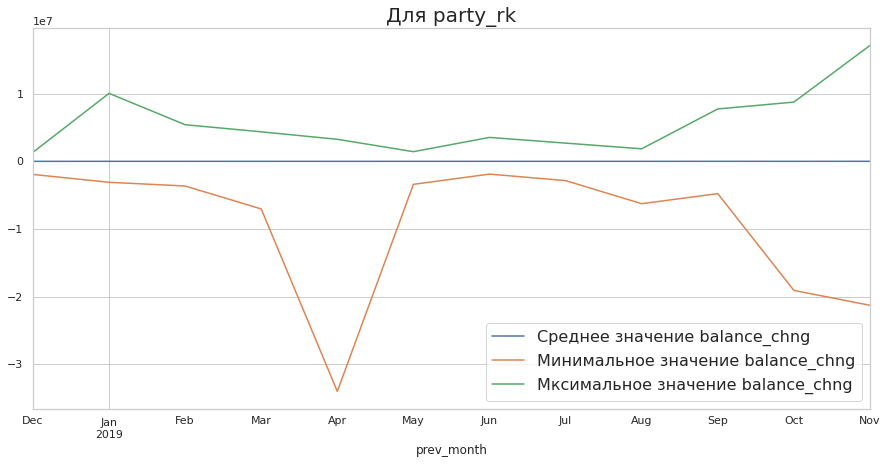

In [11]:
tmp = balance_data.groupby(['party_rk', 'prev_month', 'cur_month']).balance_chng.sum().reset_index()
tmp.groupby(['prev_month']).balance_chng.mean().plot(label='Среднее значение balance_chng', figsize=(15, 7))
tmp.groupby(['prev_month']).balance_chng.min().plot(label='Минимальное значение balance_chng')
tmp.groupby(['prev_month']).balance_chng.max().plot(label='Мксимальное значение balance_chng')
plt.legend(fontsize=16)
plt.title('Для party_rk', fontsize=20)

In [12]:
"""
Убираем чуваков, у которых слишком большое абсолютное значение balance_chng хотя бы в одном месяце, их 319
"""
big_boys = set(balance_data[abs(balance_data.balance_chng) > 500000].party_rk.values)
b_data = balance_data[balance_data.party_rk.apply(lambda s: not s in big_boys)].reset_index().drop(columns=['index'])
len(big_boys)

319

In [13]:
"""
Суммируем все  balance_chng по party_rk
account_rk не рассматривается
"""
b_data_party_rk_grouped = b_data.groupby(['party_rk', 'cur_month']).balance_chng.sum().reset_index()
b_data_unst = b_data_party_rk_grouped.set_index(['party_rk', 'cur_month']).unstack()

## убираем чуваков, у которых есть Nan есть хотя бы в одном месяце, таких 17940
shape1 = b_data_unst.shape[0]
b_data_unst = b_data_unst.dropna()
shape2 = b_data_unst.shape[0]
shape1 - shape2


17940

In [14]:
b_data = b_data_unst.stack().reset_index()

In [15]:
#сет party_rk, которые рассматриваем дальше, их 31254
set_of_needed_party_rk = set(b_data_unst.reset_index().party_rk.values)
len(set_of_needed_party_rk)

31254

## 2. Добавляем фичи

### socdem

In [16]:
# берем только наших чуваков
socdem_data = socdem_data[socdem_data.party_rk.apply(lambda s: s in set_of_needed_party_rk)]
products_data = products_data[products_data.party_rk.apply(lambda s : s in set_of_needed_party_rk)]


In [17]:
def gender_code(gender):
  if gender == 'F':
    return 0
  elif gender == 'M':
    return 1
  else:
     return 1 ## пять человек без гендера будут мужчинами

socdem_data['children_flg'] = socdem_data.children_cnt.apply(lambda s: np.sign(s)) # фича наличия ребенка
socdem_data['gender_flg'] = socdem_data.gender_cd.apply(lambda s: gender_code(s)) # фича гендера


In [18]:
"""
Вот и получили таблицу с фичами и таргетами 
balance_with_target
"""
tmp = b_data.groupby(['party_rk', 'cur_month']).balance_chng.sum().unstack().reset_index()
balance_with_target = pd.merge(tmp, socdem_data[['party_rk', 'region_flg', 'children_flg', 'gender_flg']], on='party_rk')
balance_with_target = pd.merge(balance_with_target, products_data, on='party_rk')
balance_with_target = balance_with_target.rename(columns = dict(zip(b_data.cur_month, b_data.cur_month.apply(lambda s: str(s)[:7]))))
balance_with_target.head()


,party_rk,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,region_flg,children_flg,gender_flg,product1,product2,product3,product4,product5,product6,product7
0,1,5000.0,5000.0,-10000.0,5000.0,0.0,10000.0,5000.0,5000.0,60000.0,-5000.0,0.0,5000.0,0,1,1,0,1,0,1,0,0,0
1,5,10000.0,-70000.0,10000.0,-60000.0,-5000.0,115000.0,0.0,0.0,15000.0,-95000.0,-105000.0,40000.0,0,1,1,0,1,0,0,1,0,0
2,7,-5000.0,110000.0,-110000.0,0.0,0.0,0.0,0.0,0.0,0.0,5000.0,0.0,25000.0,0,1,1,0,0,0,1,0,0,0
3,8,0.0,0.0,95000.0,0.0,0.0,0.0,0.0,0.0,-5000.0,5000.0,0.0,0.0,0,1,0,0,1,0,0,1,0,0
4,11,0.0,0.0,-5000.0,-10000.0,-5000.0,-5000.0,-5000.0,0.0,-5000.0,0.0,0.0,-5000.0,0,1,0,0,1,0,0,0,0,0


## 3. Train Test Split, Scaling

In [19]:
X = balance_with_target.drop(columns=['party_rk', 'product1', 'product2', 'product3', 'product4', 'product5', 'product6', 'product7']).values
y = balance_with_target[['product1', 'product2', 'product3', 'product4', 'product5', 'product6', 'product7']].values

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [21]:
std = StandardScaler()
X_train_scl = std.fit_transform(X_train)
X_test_scl = std.transform(X_test)

In [22]:
# rfc = RandomForestClassifier(n_estimators =1000)
# rfc.fit(X_train_scl, y_train)
# rfc.feature_importances_


## 4. Pytorch model

In [23]:
batch_size=200

In [24]:
X_train_tensor = torch.from_numpy(X_train).type(torch.FloatTensor)
X_test_tensor = torch.Tensor(X_test).type(torch.FloatTensor)
y_train_tensor = torch.from_numpy(y_train).type(torch.FloatTensor)
y_test_tensor = torch.Tensor(y_test).type(torch.FloatTensor)

train_dataset = TensorDataset( X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, num_workers=2, shuffle=True,  drop_last = True)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, num_workers=2, shuffle=True, pin_memory=True)

In [30]:
hidden1 = 256
hidden2 = 1024
hidden3 = 64

class Model(nn.Module):
    def __init__(self,input_size,output_size):
        super(Model,self).__init__()

        self.fc1 = nn.Sequential(
            nn.BatchNorm1d(input_size),
            nn.Dropout(p=.5),
            nn.Linear(input_size, hidden1),
            nn.LeakyReLU(),
            
        )
        self.fc2 = nn.Sequential(
            nn.BatchNorm1d(hidden1),
            nn.Dropout(p=.5),
            nn.Linear(hidden1, hidden2),  
            nn.LeakyReLU(),
        )

        self.fc3 = nn.Sequential(
            nn.BatchNorm1d(hidden2),
            nn.Dropout(p=.5),
            nn.Linear(hidden2, hidden3),  
            nn.ReLU(),
        )

        self.fc4 = nn.Sequential(
            nn.BatchNorm1d(hidden3),
            nn.Linear(hidden3, output_size),
            nn.Sigmoid()           
        )


        
    def forward(self,x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        
        return x

In [31]:
from torchsummary import summary

model = Model(X_train.shape[1], y_train.shape[1]).cuda()
summary(model, input_size=(X_train.shape[1], ), batch_size=batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm1d-1                  [200, 15]              30
           Dropout-2                  [200, 15]               0
            Linear-3                 [200, 256]           4,096
         LeakyReLU-4                 [200, 256]               0
       BatchNorm1d-5                 [200, 256]             512
           Dropout-6                 [200, 256]               0
            Linear-7                [200, 1024]         263,168
         LeakyReLU-8                [200, 1024]               0
       BatchNorm1d-9                [200, 1024]           2,048
          Dropout-10                [200, 1024]               0
           Linear-11                  [200, 64]          65,600
             ReLU-12                  [200, 64]               0
      BatchNorm1d-13                  [200, 64]             128
           Linear-14                   

In [34]:
def get_batch_mean_cosine_similarity(model, dataloader):
    for x, y in dataloader:
        prediction = model(x.cuda())
        batch_mean_cosine_similarity = cosine_similarity(np.array(prediction.tolist()), y.numpy()).trace()/batch_size

    return batch_mean_cosine_similarity

def train(model, optimizer, criterion,  scheduler=None, epochs_n=20):  
    model.cuda()

    learning_curve = []
    train_curve = [np.nan] * epochs_n
    test_curve = [np.nan] * epochs_n
    max_test_cossim = 0
    max_cossim_epoch = 0
    train_size = len(train_loader)
    

    for epoch in trange(epochs_n):
            
        model.train()

    
        for x, y in train_loader:
            optimizer.zero_grad()
            prediction = model(x.cuda())
            loss = criterion(prediction, y.cuda())
            learning_curve.append(loss.item())
            loss.backward()
            optimizer.step()

        display.clear_output(wait=True)
        f, axes = plt.subplots(1, 2, figsize=(15, 3))

#         learning_curve
        axes[0].plot(learning_curve)
        axes[0].set_title('BCEWithLogitsLoss')

        model.eval()
        train_curve[epoch] = get_batch_mean_cosine_similarity(model, train_loader)
        test_curve[epoch] = get_batch_mean_cosine_similarity(model, test_loader)
        
        test_cossim = test_curve[epoch]
        if test_cossim > max_test_cossim:
            max_test_cossim = test_cossim
            max_cossim_epoch = epoch
            model_dir = os.getcwd()+"/best_model"
            torch.save(model, model_dir)
        if scheduler is not None:  
            scheduler.step()   
        axes[1].set_title('Train {:.4f}, test {:.4f}, max test {:.4f} at {}'.format(
            train_curve[epoch], test_cossim, max_test_cossim, max_cossim_epoch))
        axes[1].plot(train_curve)
        axes[1].plot(test_curve)
        
        plt.tight_layout()
        plt.show()


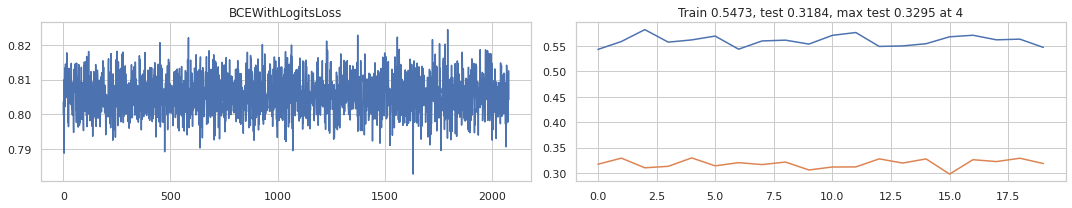




100%|██████████| 20/20 [00:51<00:00,  2.59s/it]


In [35]:
criterion = nn.BCEWithLogitsLoss()
lr = 0.0001
weight_decay = 0.003
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)



milestones = [25, 50, 75]
gamma = 0.1
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)

model = Model(X_train.shape[1], y_train.shape[1]).cuda()


train(model=model, criterion=criterion, optimizer=optimizer, scheduler=None)
